# Flood Model Training Notebook

Train a Flood ConvLSTM Model using `usl_models` lib.

In [1]:

import tensorflow as tf
import keras_tuner
import time
import keras
import logging
from usl_models.flood_ml import constants
from usl_models.flood_ml.model import FloodModel
from usl_models.flood_ml.model_params import FloodModelParams
from usl_models.flood_ml.dataset import load_dataset_windowed, load_dataset

# Setup
logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
    
timestamp = time.strftime("%Y%m%d-%H%M%S")

# Cities and their config folders
city_config_mapping = {
    "Manhattan": "Manhattan_config",
    "Atlanta": "Atlanta_config",
    "Phoenix_SM": "PHX_SM",
    "Phoenix_PV": "PHX_PV",
}

# Rainfall files you want
rainfall_files = [5]  # Only 5 and 6

# Generate sim_names
sim_names = []
for city, config in city_config_mapping.items():
    for rain_id in rainfall_files:
        sim_name = f"{city}-{config}/Rainfall_Data_{rain_id}.txt"
        sim_names.append(sim_name)

print(f"Training on {len(sim_names)} simulations.")
for s in sim_names:
    print(s)

# Now load dataset
train_dataset = load_dataset_windowed(
    sim_names=sim_names,
    batch_size=4,
    dataset_split='train'
).cache()

validation_dataset = load_dataset_windowed(
    sim_names=sim_names,
    batch_size=4,
    dataset_split='val'
).cache()

# Now you can pass these into your model training like usual


2025-05-01 15:19:36.723276: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-01 15:19:36.773826: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-01 15:19:36.773860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-01 15:19:36.775088: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-01 15:19:36.782915: I tensorflow/core/platform/cpu_feature_guar

Training on 4 simulations.
Manhattan-Manhattan_config/Rainfall_Data_5.txt
Atlanta-Atlanta_config/Rainfall_Data_5.txt
Phoenix_SM-PHX_SM/Rainfall_Data_5.txt
Phoenix_PV-PHX_PV/Rainfall_Data_5.txt


2025-05-01 15:19:41.673704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38380 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [5]:

tuner = keras_tuner.BayesianOptimization(
    FloodModel.get_hypermodel(
        lstm_units=[32, 64, 128],
        lstm_kernel_size=[3, 5],
        lstm_dropout=[0.2, 0.3],
        lstm_recurrent_dropout=[0.2, 0.3],
        n_flood_maps=[5],
        m_rainfall=[6],
    ),
        objective="val_loss",
        max_trials=1,
        project_name=f"logs/htune_project_{timestamp}",
)

tuner.search_space_summary()


2025-04-30 18:25:52.193340: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Search space summary
Default search space size: 6
lstm_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
lstm_kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
lstm_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3], 'ordered': True}
lstm_recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3], 'ordered': True}
n_flood_maps (Choice)
{'default': 5, 'conditions': [], 'values': [5], 'ordered': True}
m_rainfall (Choice)
{'default': 6, 'conditions': [], 'values': [6], 'ordered': True}


In [6]:
log_dir = f"logs/htune_project_{timestamp}"
print(log_dir)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
tuner.search(train_dataset, epochs=1, validation_data=validation_dataset , callbacks=[tb_callback])
best_model, best_hp = tuner.get_best_models()[0], tuner.get_best_hyperparameters()[0]
best_hp.values

Trial 1 Complete [00h 01m 12s]
val_loss: 0.008071048185229301

Best val_loss So Far: 0.008071048185229301
Total elapsed time: 00h 01m 12s


{'lstm_units': 64,
 'lstm_kernel_size': 3,
 'lstm_dropout': 0.3,
 'lstm_recurrent_dropout': 0.3,
 'n_flood_maps': 5,
 'm_rainfall': 6}

In [7]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define final parameters and model
final_params = FloodModel.Params(**best_hp.values)
model = FloodModel(params=final_params)

# Define callbacks
callbacks = [
    keras.callbacks.TensorBoard(log_dir=log_dir),
    ModelCheckpoint(
        filepath=log_dir + "/checkpoint",
        save_best_only=True,
        monitor="val_loss",
        mode="min",
        save_format="tf"
    ),
    EarlyStopping(               # <--- ADD THIS
        monitor="val_loss",       # What to monitor
        patience=10,              # Number of epochs with no improvement to wait
        restore_best_weights=True, # Restore model weights from best epoch
        mode="min"                # "min" because lower val_loss is better
    )
]

# Train
model.fit(
    train_dataset,
    validation_dataset,
    epochs=200,
    callbacks=callbacks
)

# Save final model
model.save_model(log_dir + "/model")


Epoch 1/200


2025-04-30 18:27:50.783445: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inflood_conv_lstm_1/conv_lstm/conv_lstm2d_1/while/body/_1/flood_conv_lstm_1/conv_lstm/conv_lstm2d_1/while/dropout_7/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


     43/Unknown - 14s 212ms/step - loss: 0.0099 - mean_absolute_error: 0.0261 - root_mean_squared_error: 0.0994

2025-04-30 18:28:01.562994: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15634308617093831071
2025-04-30 18:28:01.563062: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11822405273339157691
2025-04-30 18:28:01.563072: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13706608023712796605
2025-04-30 18:28:04.007063: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12675665506891802873
2025-04-30 18:28:04.007127: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3429371086893421341
2025-04-30 18:28:04.007144: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13882962061490058347
2025-04-30 18:28:04.007152: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous rec

INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 21s 364ms/step - loss: 0.0099 - mean_absolute_error: 0.0261 - root_mean_squared_error: 0.0994 - val_loss: 0.0080 - val_mean_absolute_error: 0.0215 - val_root_mean_squared_error: 0.0895
Epoch 2/200
43/43 [==============================] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0213 - root_mean_squared_error: 0.0853WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 354ms/step - loss: 0.0073 - mean_absolute_error: 0.0213 - root_mean_squared_error: 0.0853 - val_loss: 0.0066 - val_mean_absolute_error: 0.0173 - val_root_mean_squared_error: 0.0811
Epoch 3/200
43/43 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0789WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 344ms/step - loss: 0.0062 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0789 - val_loss: 0.0059 - val_mean_absolute_error: 0.0153 - val_root_mean_squared_error: 0.0769
Epoch 4/200
43/43 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0796WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 352ms/step - loss: 0.0063 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0796 - val_loss: 0.0059 - val_mean_absolute_error: 0.0152 - val_root_mean_squared_error: 0.0768
Epoch 5/200
43/43 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0742WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 342ms/step - loss: 0.0055 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0742 - val_loss: 0.0053 - val_mean_absolute_error: 0.0150 - val_root_mean_squared_error: 0.0728
Epoch 6/200
43/43 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0720WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 344ms/step - loss: 0.0052 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0720 - val_loss: 0.0050 - val_mean_absolute_error: 0.0147 - val_root_mean_squared_error: 0.0707
Epoch 7/200
43/43 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0705WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 355ms/step - loss: 0.0050 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0705 - val_loss: 0.0048 - val_mean_absolute_error: 0.0145 - val_root_mean_squared_error: 0.0692
Epoch 8/200
43/43 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0692WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 343ms/step - loss: 0.0048 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0692 - val_loss: 0.0046 - val_mean_absolute_error: 0.0144 - val_root_mean_squared_error: 0.0678
Epoch 9/200
43/43 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0683WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 342ms/step - loss: 0.0047 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0683 - val_loss: 0.0045 - val_mean_absolute_error: 0.0144 - val_root_mean_squared_error: 0.0668
Epoch 10/200
43/43 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0668WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 356ms/step - loss: 0.0045 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0668 - val_loss: 0.0043 - val_mean_absolute_error: 0.0136 - val_root_mean_squared_error: 0.0655
Epoch 11/200
43/43 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0656WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 344ms/step - loss: 0.0043 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0656 - val_loss: 0.0041 - val_mean_absolute_error: 0.0136 - val_root_mean_squared_error: 0.0643
Epoch 12/200
43/43 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0644WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 342ms/step - loss: 0.0042 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0644 - val_loss: 0.0040 - val_mean_absolute_error: 0.0133 - val_root_mean_squared_error: 0.0630
Epoch 13/200
43/43 [==============================] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0636WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 342ms/step - loss: 0.0040 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0636 - val_loss: 0.0038 - val_mean_absolute_error: 0.0132 - val_root_mean_squared_error: 0.0619
Epoch 14/200
43/43 [==============================] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0633WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 16s 364ms/step - loss: 0.0040 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0633 - val_loss: 0.0038 - val_mean_absolute_error: 0.0132 - val_root_mean_squared_error: 0.0612
Epoch 15/200
43/43 [==============================] - 11s 258ms/step - loss: 0.0040 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0631 - val_loss: 0.0038 - val_mean_absolute_error: 0.0134 - val_root_mean_squared_error: 0.0613
Epoch 16/200
43/43 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0613WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 348ms/step - loss: 0.0038 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0613 - val_loss: 0.0036 - val_mean_absolute_error: 0.0127 - val_root_mean_squared_error: 0.0598
Epoch 17/200
43/43 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0605WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 346ms/step - loss: 0.0037 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0605 - val_loss: 0.0035 - val_mean_absolute_error: 0.0130 - val_root_mean_squared_error: 0.0587
Epoch 18/200
43/43 [==============================] - ETA: 0s - loss: 0.0035 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0593WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 16s 364ms/step - loss: 0.0035 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0593 - val_loss: 0.0033 - val_mean_absolute_error: 0.0124 - val_root_mean_squared_error: 0.0576
Epoch 19/200
43/43 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0585WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 344ms/step - loss: 0.0034 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0585 - val_loss: 0.0033 - val_mean_absolute_error: 0.0123 - val_root_mean_squared_error: 0.0571
Epoch 20/200
43/43 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0579WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 345ms/step - loss: 0.0034 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0579 - val_loss: 0.0032 - val_mean_absolute_error: 0.0122 - val_root_mean_squared_error: 0.0564
Epoch 21/200
43/43 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0581WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 343ms/step - loss: 0.0034 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0581 - val_loss: 0.0031 - val_mean_absolute_error: 0.0125 - val_root_mean_squared_error: 0.0559
Epoch 22/200
43/43 [==============================] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0575WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 360ms/step - loss: 0.0033 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0575 - val_loss: 0.0031 - val_mean_absolute_error: 0.0121 - val_root_mean_squared_error: 0.0555
Epoch 23/200
43/43 [==============================] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0564WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 344ms/step - loss: 0.0032 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0564 - val_loss: 0.0030 - val_mean_absolute_error: 0.0120 - val_root_mean_squared_error: 0.0547
Epoch 24/200
43/43 [==============================] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0559WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 343ms/step - loss: 0.0031 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0559 - val_loss: 0.0029 - val_mean_absolute_error: 0.0120 - val_root_mean_squared_error: 0.0542
Epoch 25/200
43/43 [==============================] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0555WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 342ms/step - loss: 0.0031 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0555 - val_loss: 0.0029 - val_mean_absolute_error: 0.0120 - val_root_mean_squared_error: 0.0537
Epoch 26/200
43/43 [==============================] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0557WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 16s 365ms/step - loss: 0.0031 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0557 - val_loss: 0.0029 - val_mean_absolute_error: 0.0121 - val_root_mean_squared_error: 0.0536
Epoch 27/200
43/43 [==============================] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0545WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 345ms/step - loss: 0.0030 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0545 - val_loss: 0.0028 - val_mean_absolute_error: 0.0117 - val_root_mean_squared_error: 0.0528
Epoch 28/200
43/43 [==============================] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0545WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 348ms/step - loss: 0.0030 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0545 - val_loss: 0.0028 - val_mean_absolute_error: 0.0117 - val_root_mean_squared_error: 0.0527
Epoch 29/200
43/43 [==============================] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0536WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 348ms/step - loss: 0.0029 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0536 - val_loss: 0.0027 - val_mean_absolute_error: 0.0116 - val_root_mean_squared_error: 0.0519
Epoch 30/200
43/43 [==============================] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0531WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 347ms/step - loss: 0.0028 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0531 - val_loss: 0.0026 - val_mean_absolute_error: 0.0116 - val_root_mean_squared_error: 0.0514
Epoch 31/200
43/43 [==============================] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0526WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 16s 371ms/step - loss: 0.0028 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0526 - val_loss: 0.0026 - val_mean_absolute_error: 0.0115 - val_root_mean_squared_error: 0.0510
Epoch 32/200
43/43 [==============================] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0522WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 346ms/step - loss: 0.0027 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0522 - val_loss: 0.0026 - val_mean_absolute_error: 0.0113 - val_root_mean_squared_error: 0.0506
Epoch 33/200
43/43 [==============================] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0518WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 342ms/step - loss: 0.0027 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0518 - val_loss: 0.0025 - val_mean_absolute_error: 0.0113 - val_root_mean_squared_error: 0.0503
Epoch 34/200
43/43 [==============================] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0518WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 343ms/step - loss: 0.0027 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0518 - val_loss: 0.0025 - val_mean_absolute_error: 0.0113 - val_root_mean_squared_error: 0.0500
Epoch 35/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0028 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0527 - val_loss: 0.0027 - val_mean_absolute_error: 0.0115 - val_root_mean_squared_error: 0.0515
Epoch 36/200
43/43 [==============================] - 11s 258ms/step - loss: 0.0028 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0532 - val_loss: 0.0026 - val_mean_absolute_error: 0.0126 - val_root_mean_squared_error: 0.0510
Epoch 37/200
43/43 [==============================] - 11s 258ms/step - loss: 0.0027 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0520 - val_loss: 0.0025 - val_mean_absolute_error: 0.0113 - val_root_mean_squared_error: 0.0500
Epoch 38/200
43/43 [==============================] - ETA

INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 16s 364ms/step - loss: 0.0027 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0515 - val_loss: 0.0024 - val_mean_absolute_error: 0.0116 - val_root_mean_squared_error: 0.0494
Epoch 39/200
43/43 [==============================] - ETA: 0s - loss: 0.0026 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0505WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 344ms/step - loss: 0.0026 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0505 - val_loss: 0.0024 - val_mean_absolute_error: 0.0111 - val_root_mean_squared_error: 0.0490
Epoch 40/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0026 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0505 - val_loss: 0.0024 - val_mean_absolute_error: 0.0116 - val_root_mean_squared_error: 0.0490
Epoch 41/200
43/43 [==============================] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0501WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 343ms/step - loss: 0.0025 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0501 - val_loss: 0.0024 - val_mean_absolute_error: 0.0111 - val_root_mean_squared_error: 0.0486
Epoch 42/200
43/43 [==============================] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0500WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 343ms/step - loss: 0.0025 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0500 - val_loss: 0.0024 - val_mean_absolute_error: 0.0114 - val_root_mean_squared_error: 0.0485
Epoch 43/200
43/43 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0495WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 343ms/step - loss: 0.0024 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0495 - val_loss: 0.0023 - val_mean_absolute_error: 0.0110 - val_root_mean_squared_error: 0.0483
Epoch 44/200
43/43 [==============================] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0499WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 16s 368ms/step - loss: 0.0025 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0499 - val_loss: 0.0023 - val_mean_absolute_error: 0.0114 - val_root_mean_squared_error: 0.0482
Epoch 45/200
43/43 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0492WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 346ms/step - loss: 0.0024 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0492 - val_loss: 0.0023 - val_mean_absolute_error: 0.0111 - val_root_mean_squared_error: 0.0478
Epoch 46/200
43/43 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0487WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 347ms/step - loss: 0.0024 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0487 - val_loss: 0.0023 - val_mean_absolute_error: 0.0112 - val_root_mean_squared_error: 0.0475
Epoch 47/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0023 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0484 - val_loss: 0.0023 - val_mean_absolute_error: 0.0108 - val_root_mean_squared_error: 0.0476
Epoch 48/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0024 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0487 - val_loss: 0.0023 - val_mean_absolute_error: 0.0114 - val_root_mean_squared_error: 0.0477
Epoch 49/200
43/43 [==============================] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0484WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for pro

INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 347ms/step - loss: 0.0023 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0484 - val_loss: 0.0022 - val_mean_absolute_error: 0.0109 - val_root_mean_squared_error: 0.0471
Epoch 50/200
43/43 [==============================] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0481WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 345ms/step - loss: 0.0023 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0481 - val_loss: 0.0022 - val_mean_absolute_error: 0.0112 - val_root_mean_squared_error: 0.0470
Epoch 51/200
43/43 [==============================] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0478WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 344ms/step - loss: 0.0023 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0478 - val_loss: 0.0022 - val_mean_absolute_error: 0.0108 - val_root_mean_squared_error: 0.0468
Epoch 52/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0023 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0479 - val_loss: 0.0022 - val_mean_absolute_error: 0.0113 - val_root_mean_squared_error: 0.0468
Epoch 53/200
43/43 [==============================] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0475WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 16s 371ms/step - loss: 0.0023 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0475 - val_loss: 0.0022 - val_mean_absolute_error: 0.0108 - val_root_mean_squared_error: 0.0467
Epoch 54/200
43/43 [==============================] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0475WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 345ms/step - loss: 0.0023 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0475 - val_loss: 0.0022 - val_mean_absolute_error: 0.0111 - val_root_mean_squared_error: 0.0465
Epoch 55/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0022 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0473 - val_loss: 0.0022 - val_mean_absolute_error: 0.0106 - val_root_mean_squared_error: 0.0466
Epoch 56/200
43/43 [==============================] - ETA: 0s - loss: 0.0022 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0473WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 344ms/step - loss: 0.0022 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0473 - val_loss: 0.0021 - val_mean_absolute_error: 0.0110 - val_root_mean_squared_error: 0.0463
Epoch 57/200
43/43 [==============================] - ETA: 0s - loss: 0.0022 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0467WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 342ms/step - loss: 0.0022 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0467 - val_loss: 0.0021 - val_mean_absolute_error: 0.0107 - val_root_mean_squared_error: 0.0461
Epoch 58/200
43/43 [==============================] - ETA: 0s - loss: 0.0022 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0467WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 344ms/step - loss: 0.0022 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0467 - val_loss: 0.0021 - val_mean_absolute_error: 0.0111 - val_root_mean_squared_error: 0.0461
Epoch 59/200
43/43 [==============================] - ETA: 0s - loss: 0.0022 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0465WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 16s 371ms/step - loss: 0.0022 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0465 - val_loss: 0.0021 - val_mean_absolute_error: 0.0107 - val_root_mean_squared_error: 0.0460
Epoch 60/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0022 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0467 - val_loss: 0.0021 - val_mean_absolute_error: 0.0111 - val_root_mean_squared_error: 0.0461
Epoch 61/200
43/43 [==============================] - ETA: 0s - loss: 0.0022 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0464WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 346ms/step - loss: 0.0022 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0464 - val_loss: 0.0021 - val_mean_absolute_error: 0.0106 - val_root_mean_squared_error: 0.0458
Epoch 62/200
43/43 [==============================] - ETA: 0s - loss: 0.0021 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0463WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 344ms/step - loss: 0.0021 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0463 - val_loss: 0.0021 - val_mean_absolute_error: 0.0111 - val_root_mean_squared_error: 0.0458
Epoch 63/200
43/43 [==============================] - ETA: 0s - loss: 0.0021 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0458WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 345ms/step - loss: 0.0021 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0458 - val_loss: 0.0021 - val_mean_absolute_error: 0.0107 - val_root_mean_squared_error: 0.0454
Epoch 64/200
43/43 [==============================] - ETA: 0s - loss: 0.0021 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0455WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 344ms/step - loss: 0.0021 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0455 - val_loss: 0.0021 - val_mean_absolute_error: 0.0110 - val_root_mean_squared_error: 0.0453
Epoch 65/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0021 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0454 - val_loss: 0.0021 - val_mean_absolute_error: 0.0106 - val_root_mean_squared_error: 0.0455
Epoch 66/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0021 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0459 - val_loss: 0.0021 - val_mean_absolute_error: 0.0110 - val_root_mean_squared_error: 0.0455
Epoch 67/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0021 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0454 - val_loss: 0.0021 - val_mean_absolute_error: 0.0105 - val_root_mean_squared_error: 0.0454
Epoch 68/200
43/43 [==============================] - ETA

INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 344ms/step - loss: 0.0021 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0454 - val_loss: 0.0020 - val_mean_absolute_error: 0.0109 - val_root_mean_squared_error: 0.0451
Epoch 69/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0020 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0451 - val_loss: 0.0020 - val_mean_absolute_error: 0.0105 - val_root_mean_squared_error: 0.0452
Epoch 70/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0021 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0454 - val_loss: 0.0020 - val_mean_absolute_error: 0.0110 - val_root_mean_squared_error: 0.0451
Epoch 71/200
43/43 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0451WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for pro

INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 347ms/step - loss: 0.0020 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0451 - val_loss: 0.0020 - val_mean_absolute_error: 0.0105 - val_root_mean_squared_error: 0.0449
Epoch 72/200
43/43 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0448WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 16s 385ms/step - loss: 0.0020 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0448 - val_loss: 0.0020 - val_mean_absolute_error: 0.0108 - val_root_mean_squared_error: 0.0448
Epoch 73/200
43/43 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0446WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 350ms/step - loss: 0.0020 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0446 - val_loss: 0.0020 - val_mean_absolute_error: 0.0105 - val_root_mean_squared_error: 0.0448
Epoch 74/200
43/43 [==============================] - 11s 258ms/step - loss: 0.0020 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0449 - val_loss: 0.0020 - val_mean_absolute_error: 0.0110 - val_root_mean_squared_error: 0.0449
Epoch 75/200
43/43 [==============================] - 11s 258ms/step - loss: 0.0020 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0447 - val_loss: 0.0020 - val_mean_absolute_error: 0.0105 - val_root_mean_squared_error: 0.0448
Epoch 76/200
43/43 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0448WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for pro

INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 349ms/step - loss: 0.0020 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0448 - val_loss: 0.0020 - val_mean_absolute_error: 0.0109 - val_root_mean_squared_error: 0.0447
Epoch 77/200
43/43 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0442WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 346ms/step - loss: 0.0020 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0442 - val_loss: 0.0020 - val_mean_absolute_error: 0.0105 - val_root_mean_squared_error: 0.0444
Epoch 78/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0019 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0441 - val_loss: 0.0020 - val_mean_absolute_error: 0.0107 - val_root_mean_squared_error: 0.0444
Epoch 79/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0019 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0441 - val_loss: 0.0020 - val_mean_absolute_error: 0.0104 - val_root_mean_squared_error: 0.0446
Epoch 80/200
43/43 [==============================] - 11s 256ms/step - loss: 0.0020 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0443 - val_loss: 0.0020 - val_mean_absolute_error: 0.0108 - val_root_mean_squared_error: 0.0445
Epoch 81/200
43/43 [==============================] - 11s

INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 341ms/step - loss: 0.0019 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0440 - val_loss: 0.0020 - val_mean_absolute_error: 0.0107 - val_root_mean_squared_error: 0.0443
Epoch 83/200
43/43 [==============================] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0437WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 341ms/step - loss: 0.0019 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0437 - val_loss: 0.0020 - val_mean_absolute_error: 0.0104 - val_root_mean_squared_error: 0.0442
Epoch 84/200
43/43 [==============================] - 11s 256ms/step - loss: 0.0019 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0439 - val_loss: 0.0020 - val_mean_absolute_error: 0.0109 - val_root_mean_squared_error: 0.0444
Epoch 85/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0019 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0437 - val_loss: 0.0020 - val_mean_absolute_error: 0.0104 - val_root_mean_squared_error: 0.0444
Epoch 86/200
43/43 [==============================] - 11s 258ms/step - loss: 0.0019 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0441 - val_loss: 0.0020 - val_mean_absolute_error: 0.0109 - val_root_mean_squared_error: 0.0444
Epoch 87/200
43/43 [==============================] - ETA

INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 16s 381ms/step - loss: 0.0019 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0435 - val_loss: 0.0019 - val_mean_absolute_error: 0.0104 - val_root_mean_squared_error: 0.0440
Epoch 88/200
43/43 [==============================] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0432WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 347ms/step - loss: 0.0019 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0432 - val_loss: 0.0019 - val_mean_absolute_error: 0.0106 - val_root_mean_squared_error: 0.0439
Epoch 89/200
43/43 [==============================] - 11s 258ms/step - loss: 0.0019 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0431 - val_loss: 0.0019 - val_mean_absolute_error: 0.0104 - val_root_mean_squared_error: 0.0441
Epoch 90/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0019 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0435 - val_loss: 0.0019 - val_mean_absolute_error: 0.0106 - val_root_mean_squared_error: 0.0439
Epoch 91/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0019 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0431 - val_loss: 0.0019 - val_mean_absolute_error: 0.0103 - val_root_mean_squared_error: 0.0439
Epoch 92/200
43/43 [==============================] - ETA

INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 342ms/step - loss: 0.0019 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0430 - val_loss: 0.0019 - val_mean_absolute_error: 0.0105 - val_root_mean_squared_error: 0.0437
Epoch 93/200
43/43 [==============================] - 11s 255ms/step - loss: 0.0018 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0429 - val_loss: 0.0019 - val_mean_absolute_error: 0.0103 - val_root_mean_squared_error: 0.0440
Epoch 94/200
43/43 [==============================] - 11s 256ms/step - loss: 0.0019 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0432 - val_loss: 0.0019 - val_mean_absolute_error: 0.0105 - val_root_mean_squared_error: 0.0438
Epoch 95/200
43/43 [==============================] - 11s 256ms/step - loss: 0.0018 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0429 - val_loss: 0.0019 - val_mean_absolute_error: 0.0103 - val_root_mean_squared_error: 0.0438
Epoch 96/200
43/43 [==============================] - 11s

INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 341ms/step - loss: 0.0018 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0427 - val_loss: 0.0019 - val_mean_absolute_error: 0.0104 - val_root_mean_squared_error: 0.0436
Epoch 98/200
43/43 [==============================] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0426WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 343ms/step - loss: 0.0018 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0426 - val_loss: 0.0019 - val_mean_absolute_error: 0.0105 - val_root_mean_squared_error: 0.0434
Epoch 99/200
43/43 [==============================] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0422WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 344ms/step - loss: 0.0018 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0422 - val_loss: 0.0019 - val_mean_absolute_error: 0.0103 - val_root_mean_squared_error: 0.0434
Epoch 100/200
43/43 [==============================] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0421WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 340ms/step - loss: 0.0018 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0421 - val_loss: 0.0019 - val_mean_absolute_error: 0.0105 - val_root_mean_squared_error: 0.0433
Epoch 101/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0018 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0422 - val_loss: 0.0019 - val_mean_absolute_error: 0.0102 - val_root_mean_squared_error: 0.0437
Epoch 102/200
43/43 [==============================] - 11s 256ms/step - loss: 0.0018 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0429 - val_loss: 0.0019 - val_mean_absolute_error: 0.0107 - val_root_mean_squared_error: 0.0438
Epoch 103/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0018 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0429 - val_loss: 0.0019 - val_mean_absolute_error: 0.0103 - val_root_mean_squared_error: 0.0439
Epoch 104/200
43/43 [==============================] -

INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 16s 385ms/step - loss: 0.0018 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0420 - val_loss: 0.0019 - val_mean_absolute_error: 0.0104 - val_root_mean_squared_error: 0.0432
Epoch 107/200
43/43 [==============================] - 11s 258ms/step - loss: 0.0018 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0421 - val_loss: 0.0019 - val_mean_absolute_error: 0.0101 - val_root_mean_squared_error: 0.0435
Epoch 108/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0018 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0424 - val_loss: 0.0019 - val_mean_absolute_error: 0.0105 - val_root_mean_squared_error: 0.0434
Epoch 109/200
43/43 [==============================] - 11s 258ms/step - loss: 0.0018 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0421 - val_loss: 0.0019 - val_mean_absolute_error: 0.0102 - val_root_mean_squared_error: 0.0434
Epoch 110/200
43/43 [==============================] -

INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/checkpoint/assets


43/43 [==============================] - 15s 346ms/step - loss: 0.0017 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0416 - val_loss: 0.0018 - val_mean_absolute_error: 0.0103 - val_root_mean_squared_error: 0.0429
Epoch 113/200
43/43 [==============================] - 11s 257ms/step - loss: 0.0017 - mean_absolute_error: 0.0113 - root_mean_squared_error: 0.0413 - val_loss: 0.0018 - val_mean_absolute_error: 0.0101 - val_root_mean_squared_error: 0.0430
Epoch 114/200
43/43 [==============================] - 11s 259ms/step - loss: 0.0017 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0415 - val_loss: 0.0018 - val_mean_absolute_error: 0.0104 - val_root_mean_squared_error: 0.0430
Epoch 115/200
43/43 [==============================] - 11s 258ms/step - loss: 0.0017 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0418 - val_loss: 0.0019 - val_mean_absolute_error: 0.0102 - val_root_mean_squared_error: 0.0434
Epoch 116/200
43/43 [==============================] -

INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/model/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250430-182544/model/assets


In [ ]:
# # Test calling the model on some data.
# inputs, labels_ = next(iter(train_dataset))
# prediction = model.call(inputs)
# prediction.shape

In [9]:

import tensorflow as tf
# Path to your saved model
model_path = "/home/jainr/climateiq-cnn-5/usl_models/notebooks/logs/htune_project_20250430-034950/model"

# Load the model
model = tf.keras.models.load_model(model_path)

In [ ]:
# # Test calling the model for n predictions
# full_dataset = load_dataset(sim_names=sim_names, batch_size=1)
# inputs, labels = next(iter(full_dataset))
# predictions = model.call_n(inputs, n=4)
# predictions.shape

2025-05-01 15:21:01.834879: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'StatefulPartitionedCall/conv_lstm/StatefulPartitionedCall/conv_lstm2d_1/StatefulPartitionedCall/while/next_iteration/_155-0-0-TransposeNCHWToNHWC-LayoutOptimizer' -> 'StatefulPartitionedCall/conv_lstm/StatefulPartitionedCall/conv_lstm2d_1/StatefulPartitionedCall/while/merge/_128', 'Func/StatefulPartitionedCall/conv_lstm/StatefulPartitionedCall/conv_lstm2d_1/StatefulPartitionedCall/while/body/_112/input/_179' -> 'StatefulPartitionedCall/conv_lstm/StatefulPartitionedCall/conv_lstm2d_1/StatefulPartitionedCall/while/body/_112/while/mul_10'}.



Sample 1 Prediction Stats:
  Min: 0.0
  Max: 1.3960816
  Mean: 0.0015338449


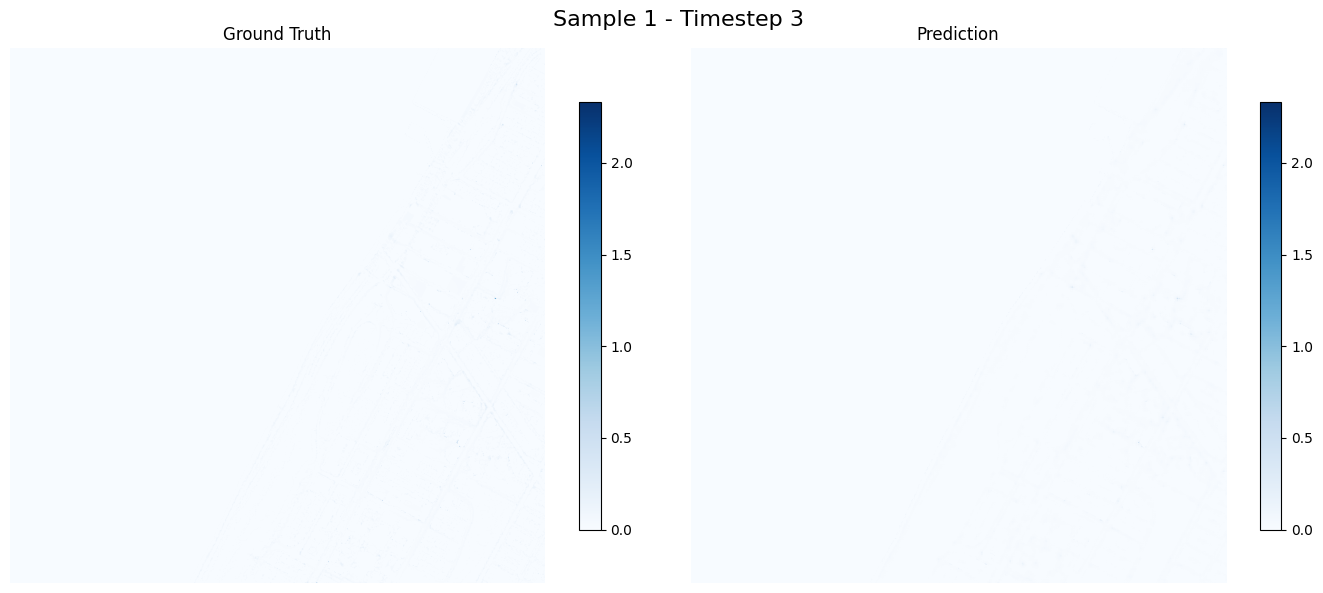


Sample 2 Prediction Stats:
  Min: 0.0
  Max: 5.486104
  Mean: 0.014712334


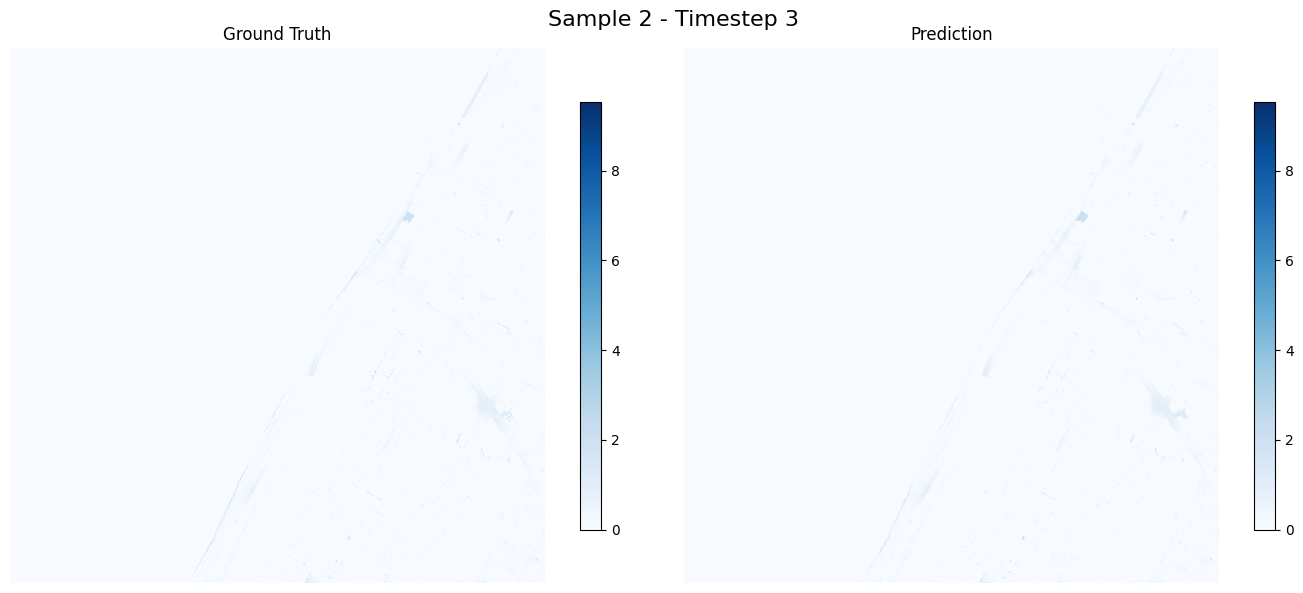


Sample 3 Prediction Stats:
  Min: 0.0
  Max: 6.237183
  Mean: 0.020508744


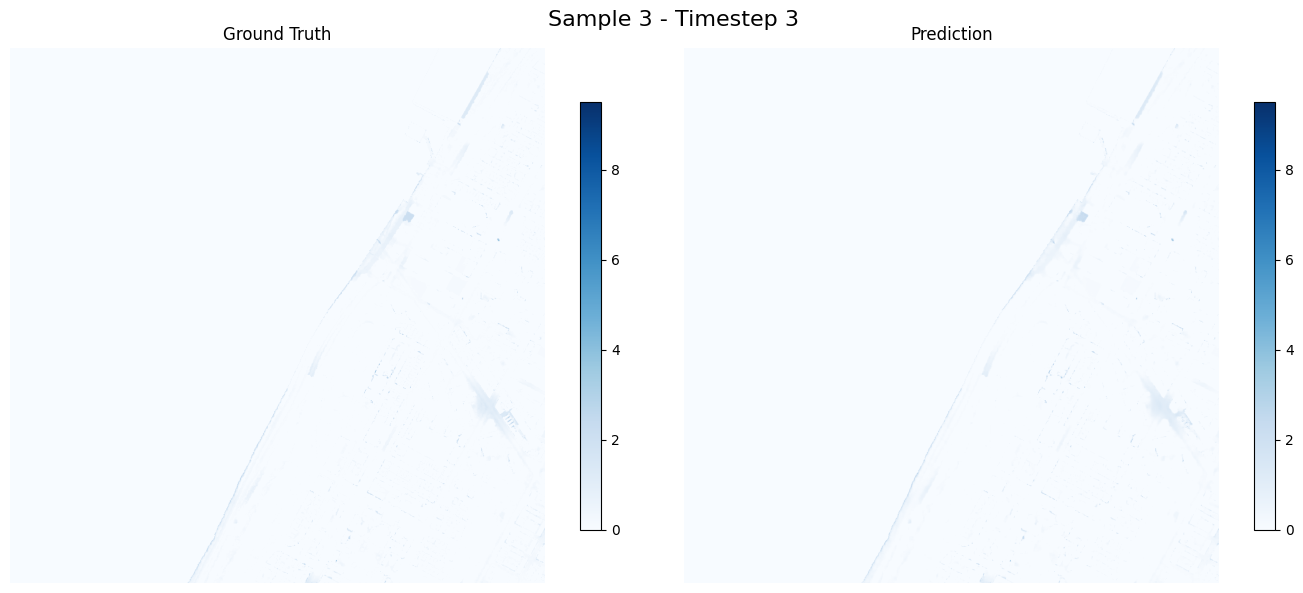


Sample 4 Prediction Stats:
  Min: 0.0
  Max: 6.4647756
  Mean: 0.0063575786


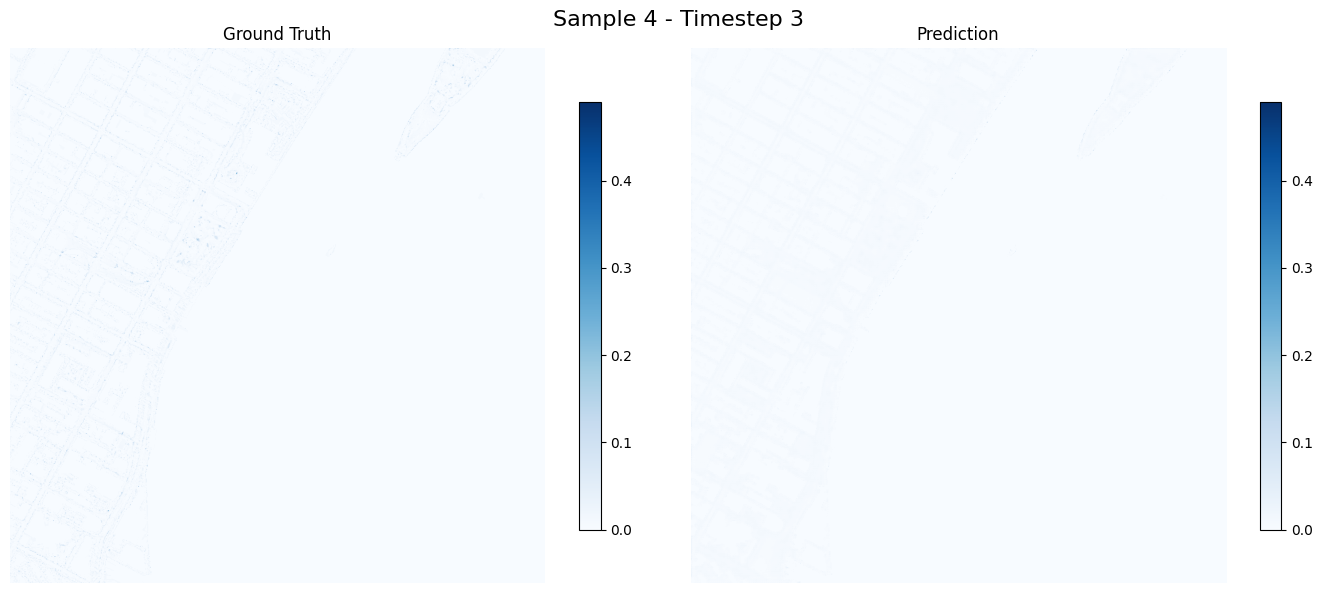


Sample 5 Prediction Stats:
  Min: 0.0
  Max: 4.1398635
  Mean: 0.0116233835


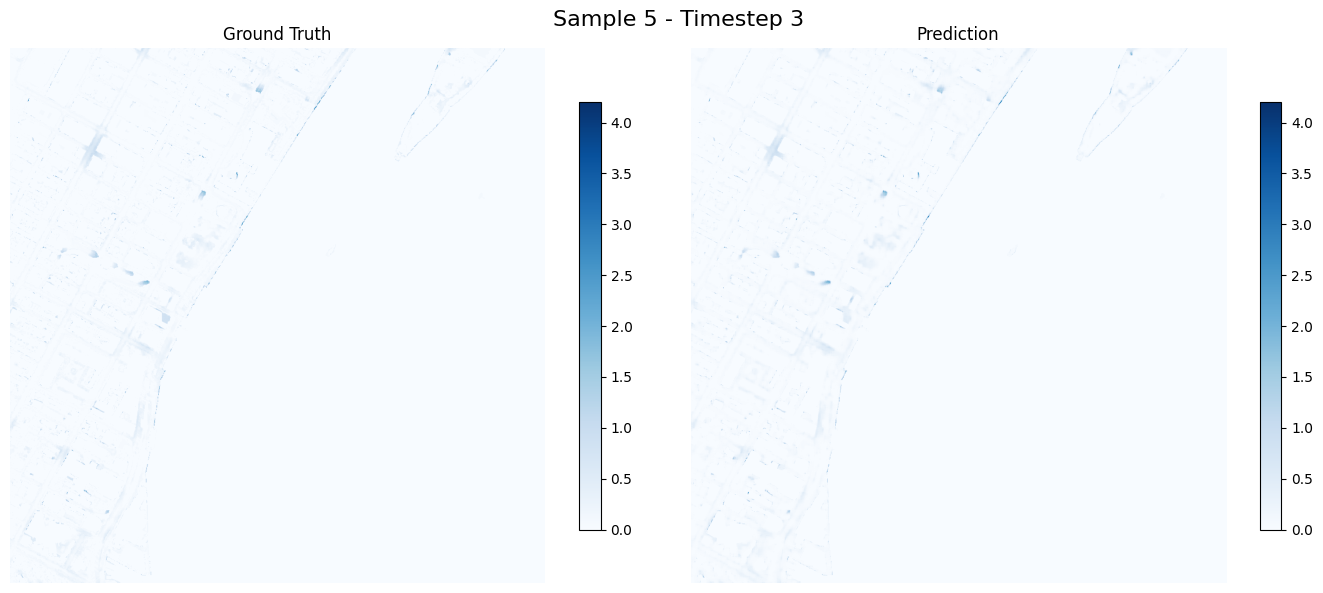


Sample 6 Prediction Stats:
  Min: 0.0
  Max: 5.3689094
  Mean: 0.02076612


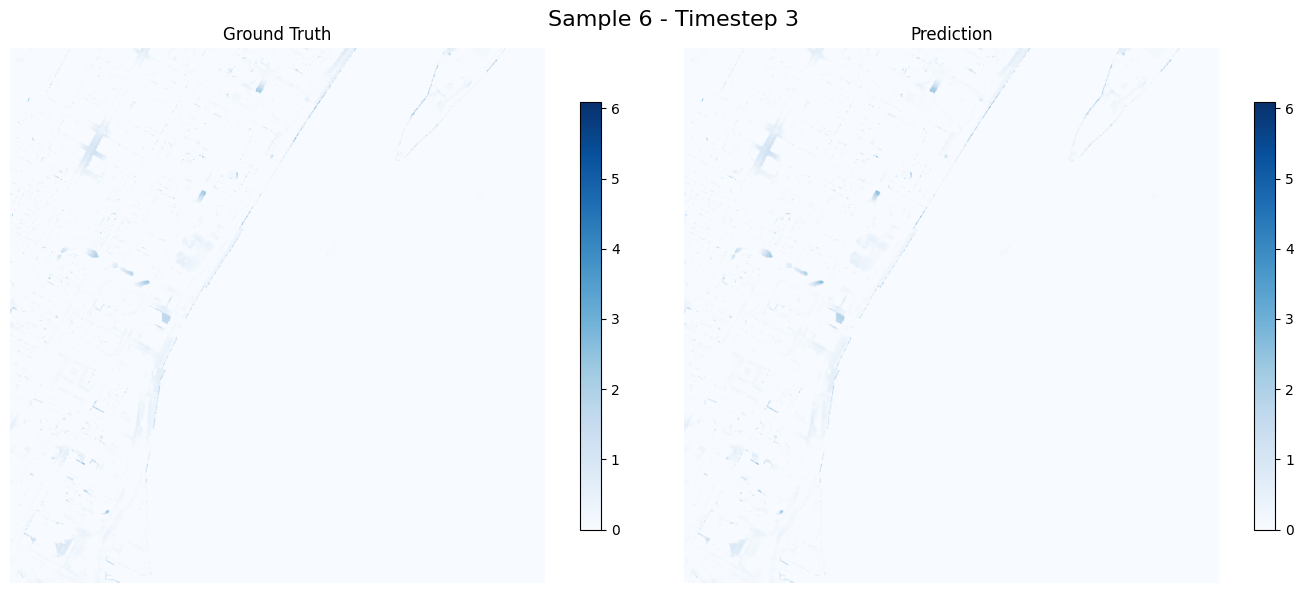


Sample 7 Prediction Stats:
  Min: 0.0
  Max: 6.03869
  Mean: 0.012653403


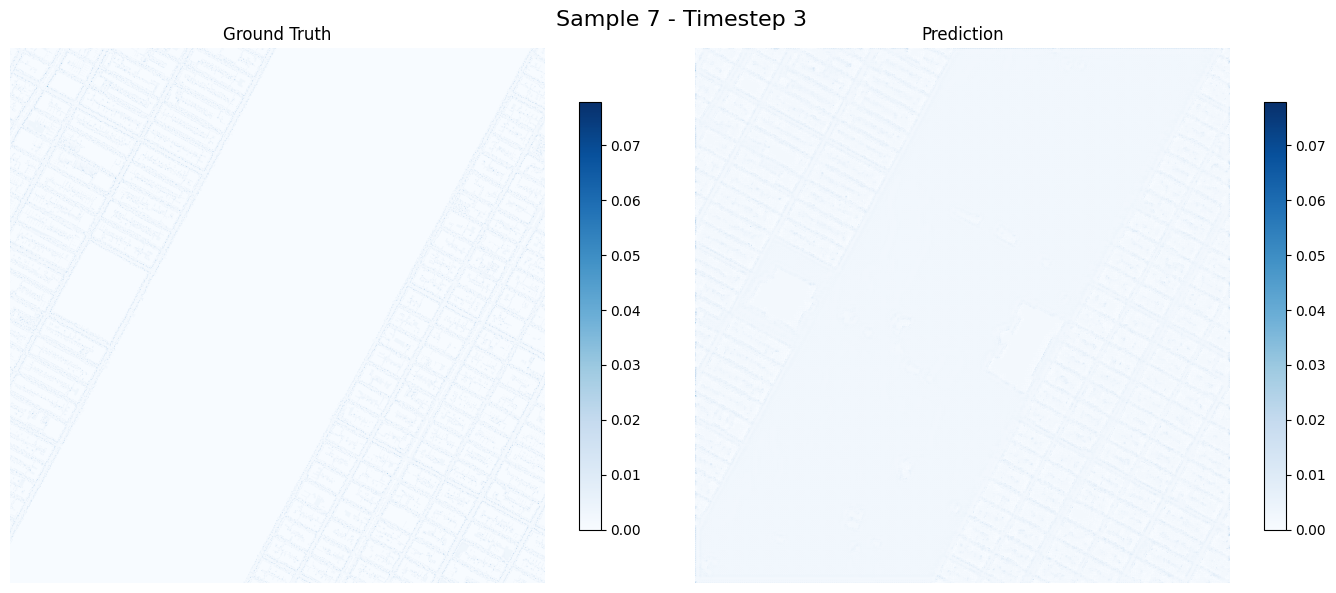


Sample 8 Prediction Stats:
  Min: 0.0
  Max: 3.082321
  Mean: 0.012415052


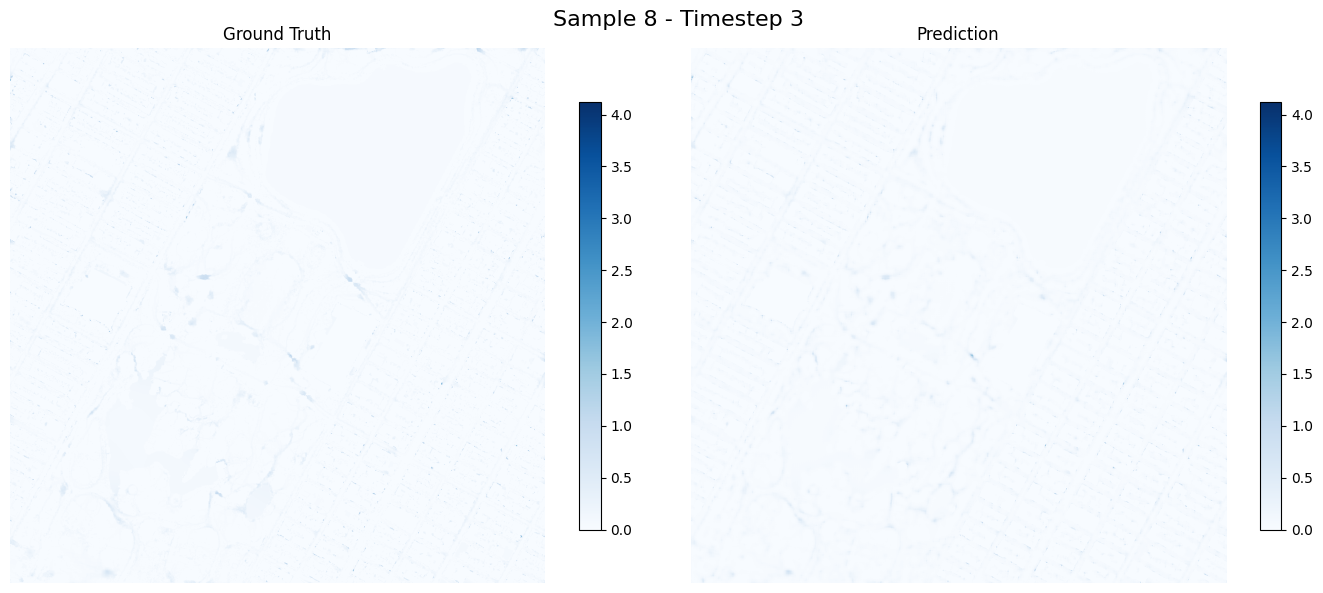


Sample 9 Prediction Stats:
  Min: 0.0
  Max: 4.4996734
  Mean: 0.03926085


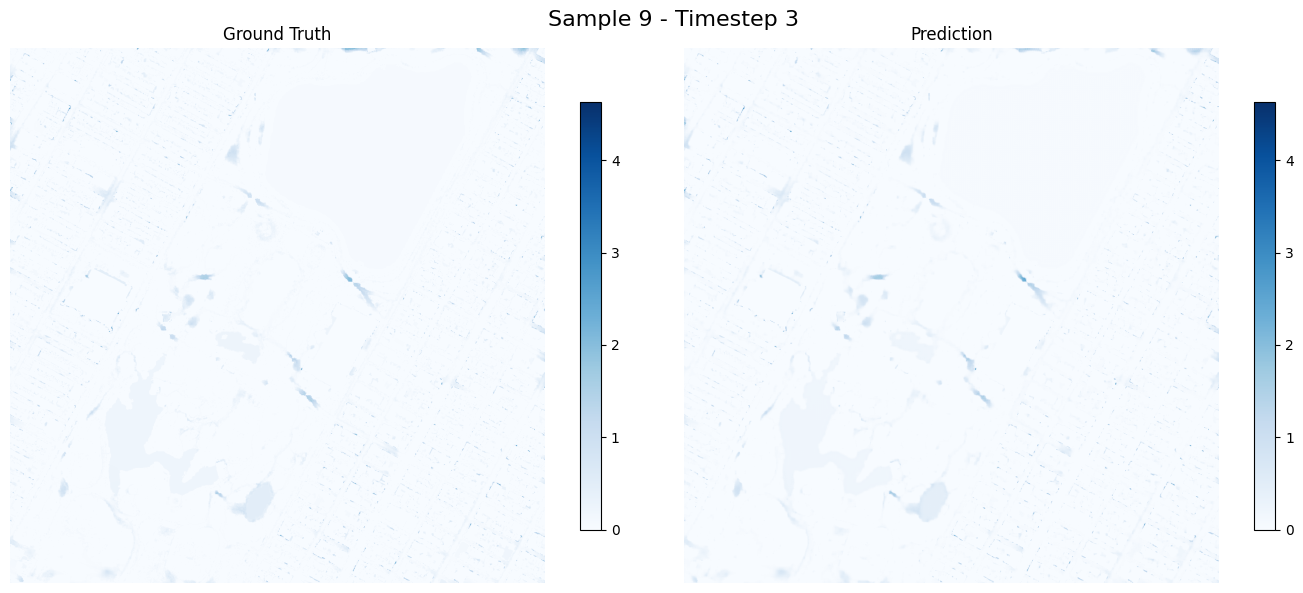


Sample 10 Prediction Stats:
  Min: 0.0
  Max: 4.237732
  Mean: 0.0329537


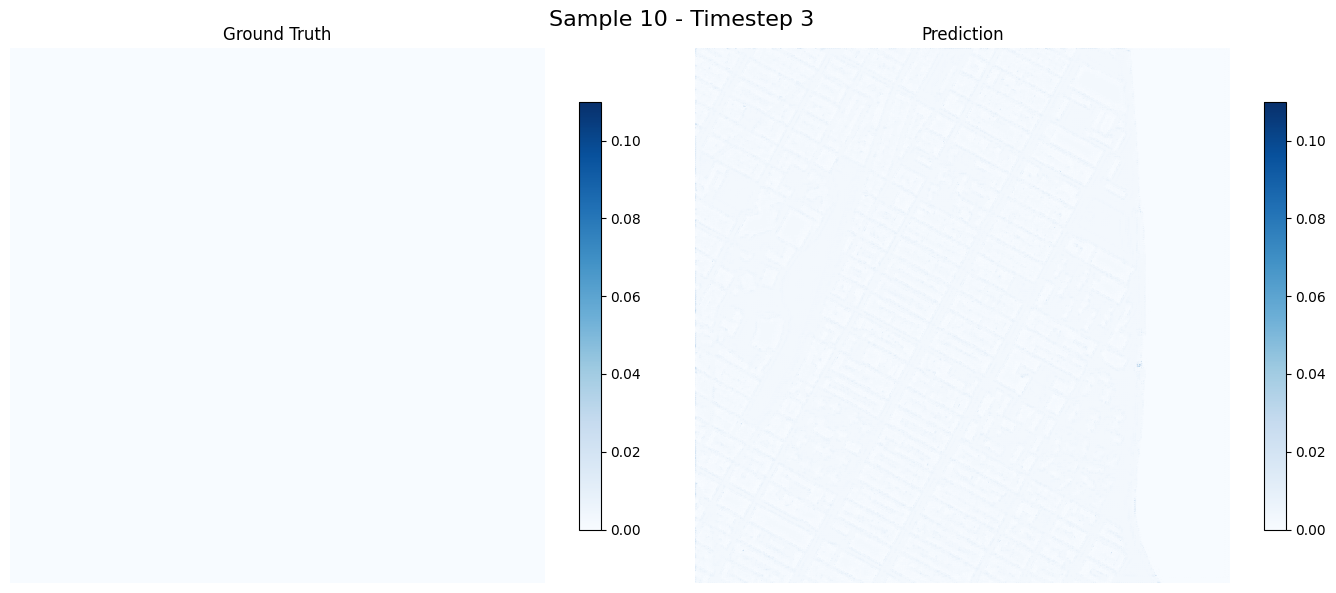


Sample 11 Prediction Stats:
  Min: 0.0
  Max: 2.4925232
  Mean: 0.0070731416


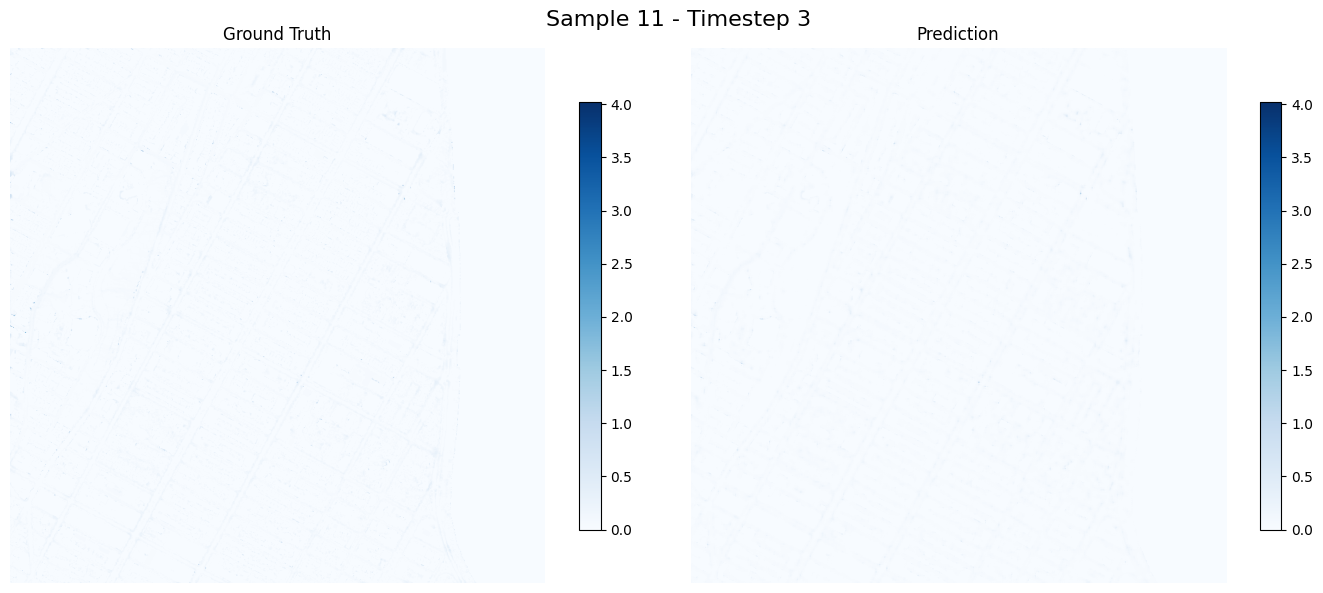


Sample 12 Prediction Stats:
  Min: 0.0
  Max: 6.0485992
  Mean: 0.0379151


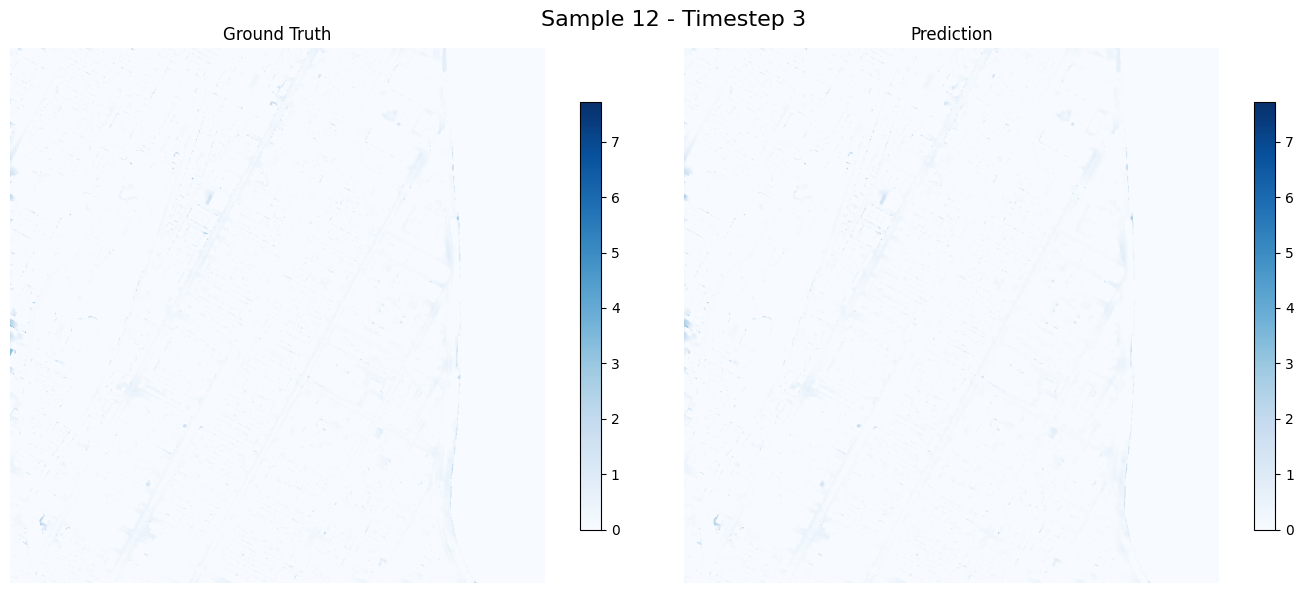


Sample 13 Prediction Stats:
  Min: 0.0
  Max: 6.667434
  Mean: 0.044818405


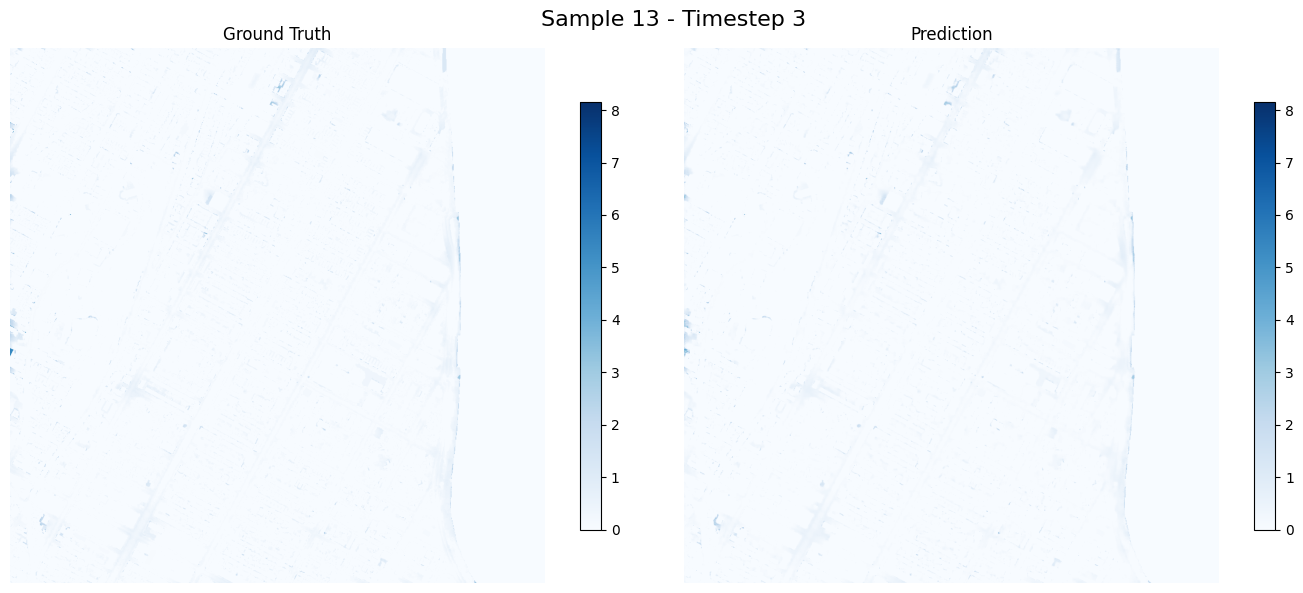


Sample 14 Prediction Stats:
  Min: 0.0
  Max: 0.6109752
  Mean: 0.0026762849


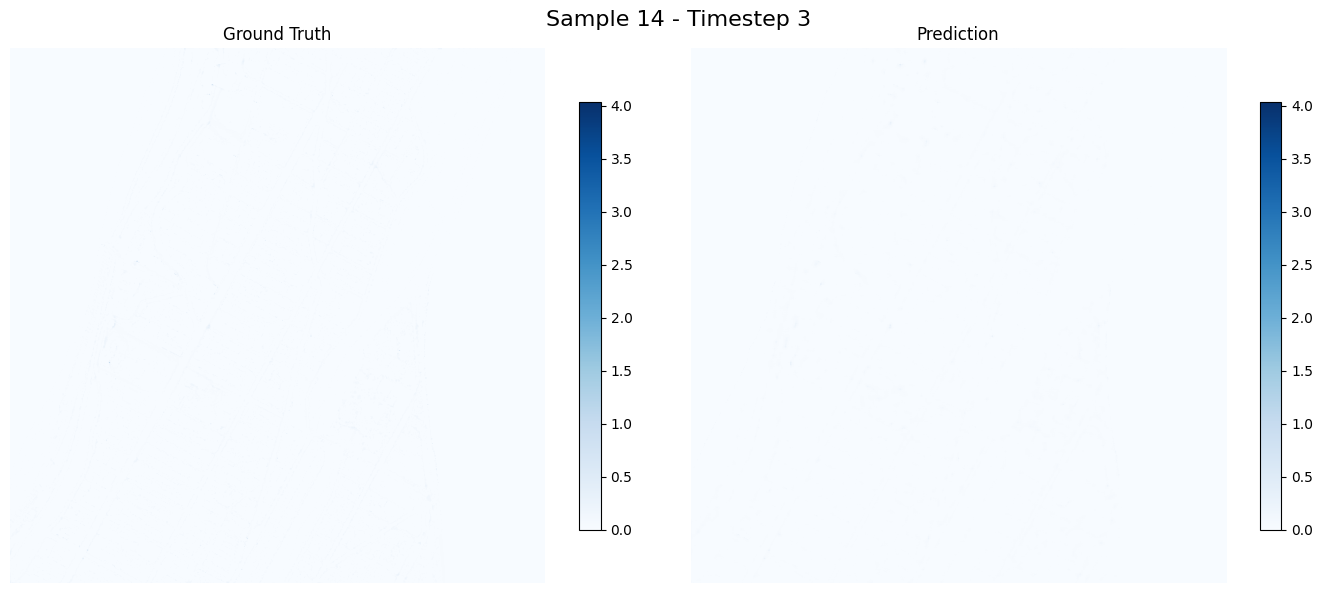


Sample 15 Prediction Stats:
  Min: 0.0
  Max: 6.9253993
  Mean: 0.024894642


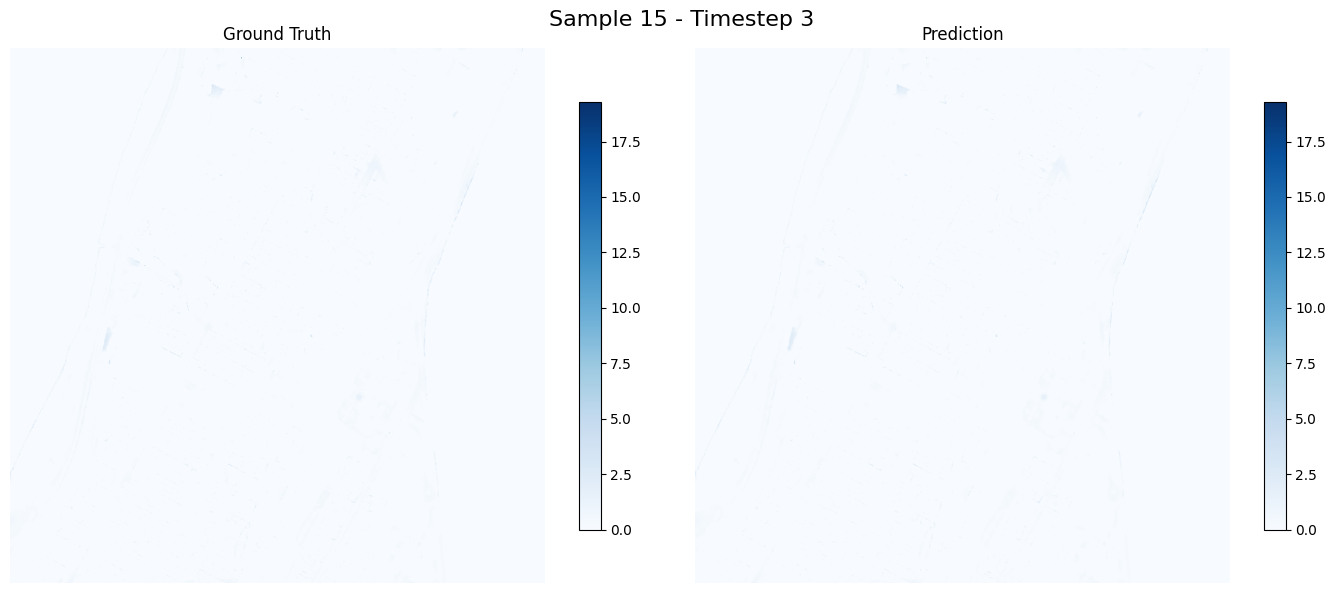


Sample 16 Prediction Stats:
  Min: 0.0
  Max: 8.292445
  Mean: 0.034417417


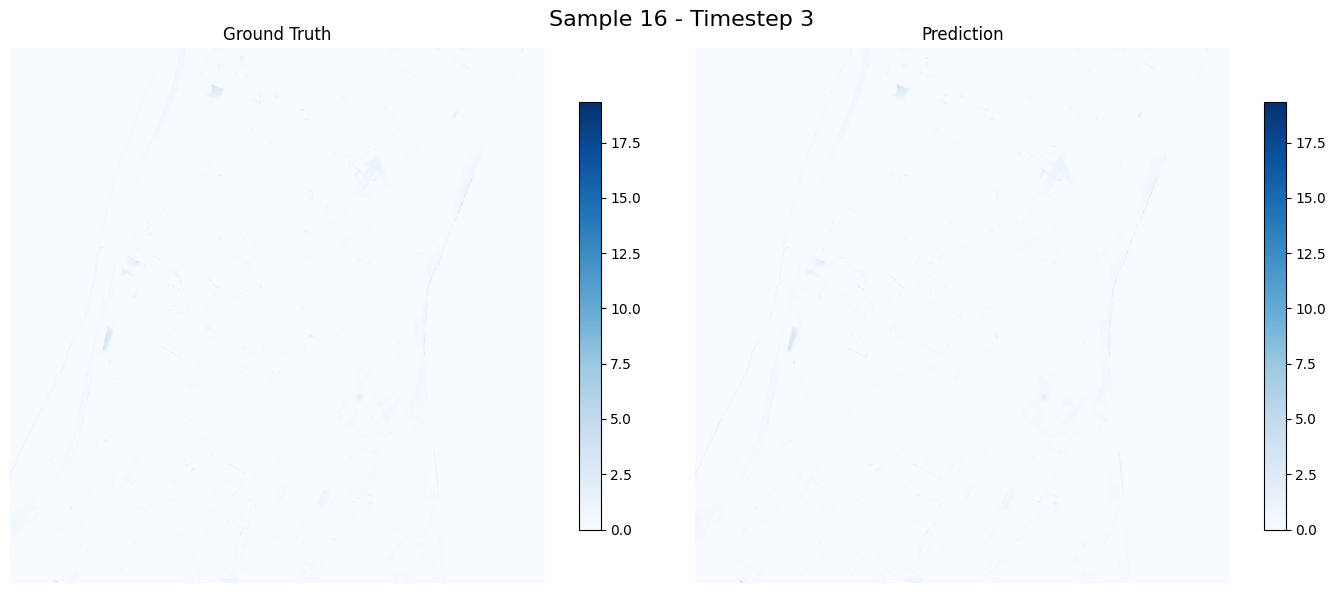


Sample 17 Prediction Stats:
  Min: 0.0
  Max: 8.290885
  Mean: 0.009695656


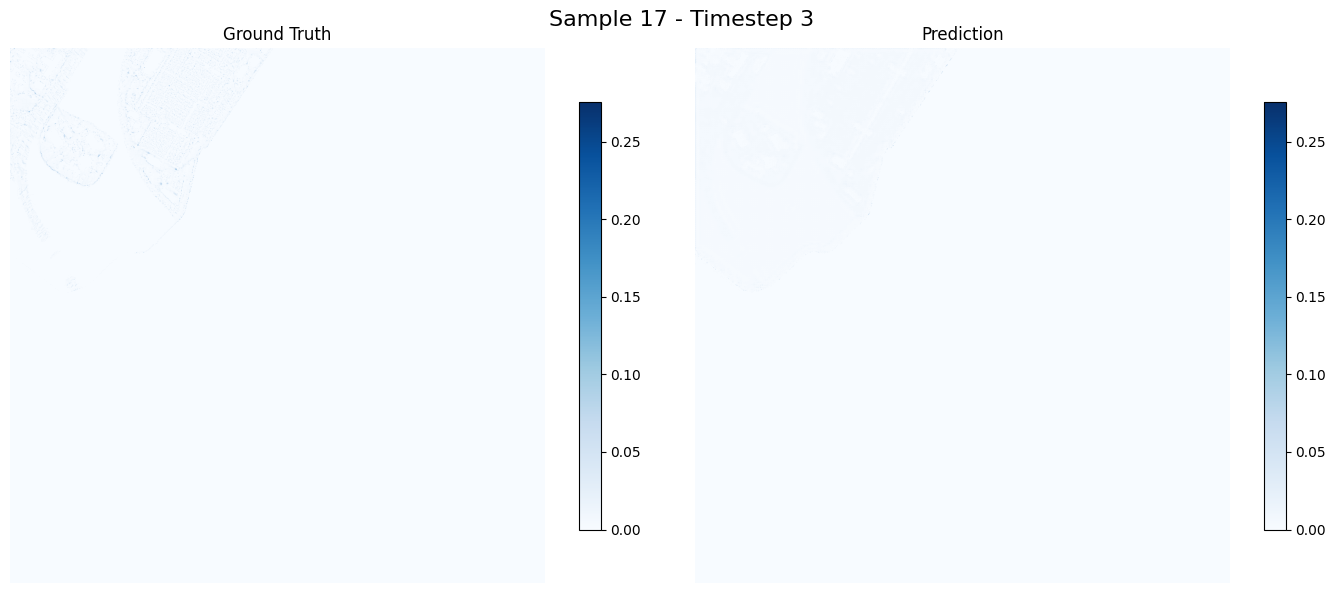


Sample 18 Prediction Stats:
  Min: 0.0
  Max: 3.9181452
  Mean: 0.003696634


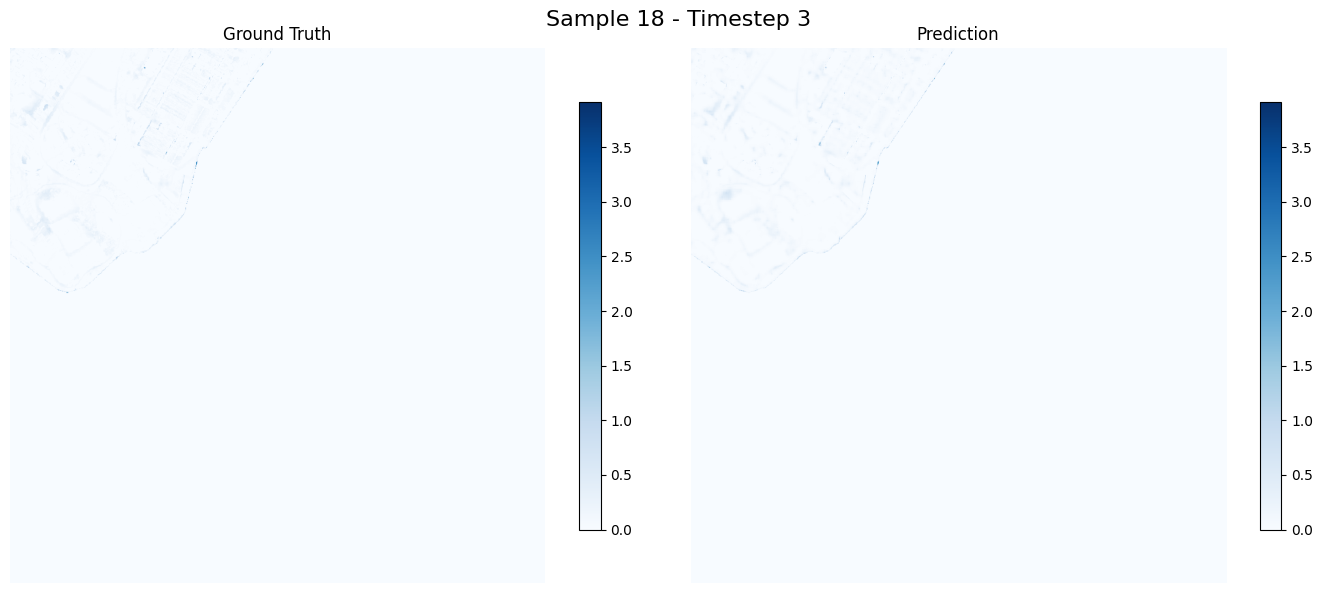


Sample 19 Prediction Stats:
  Min: 0.0
  Max: 5.303973
  Mean: 0.006592639


2025-05-01 15:21:16.326869: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


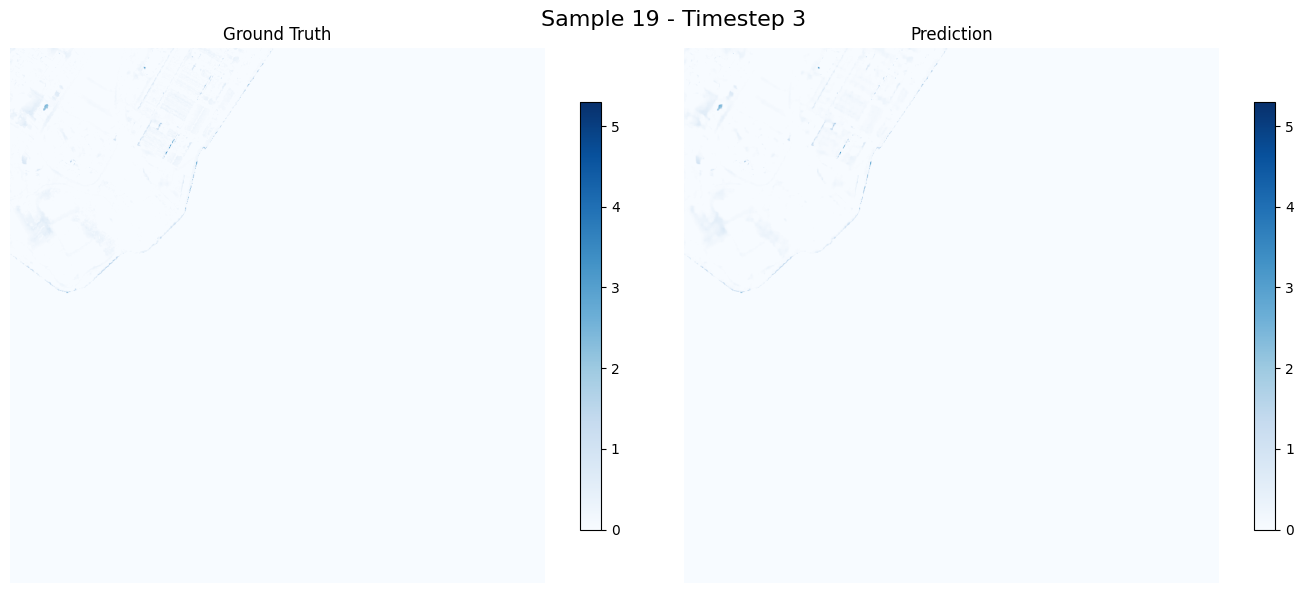


Sample 20 Prediction Stats:
  Min: 0.0
  Max: 5.370005
  Mean: 0.0047997483


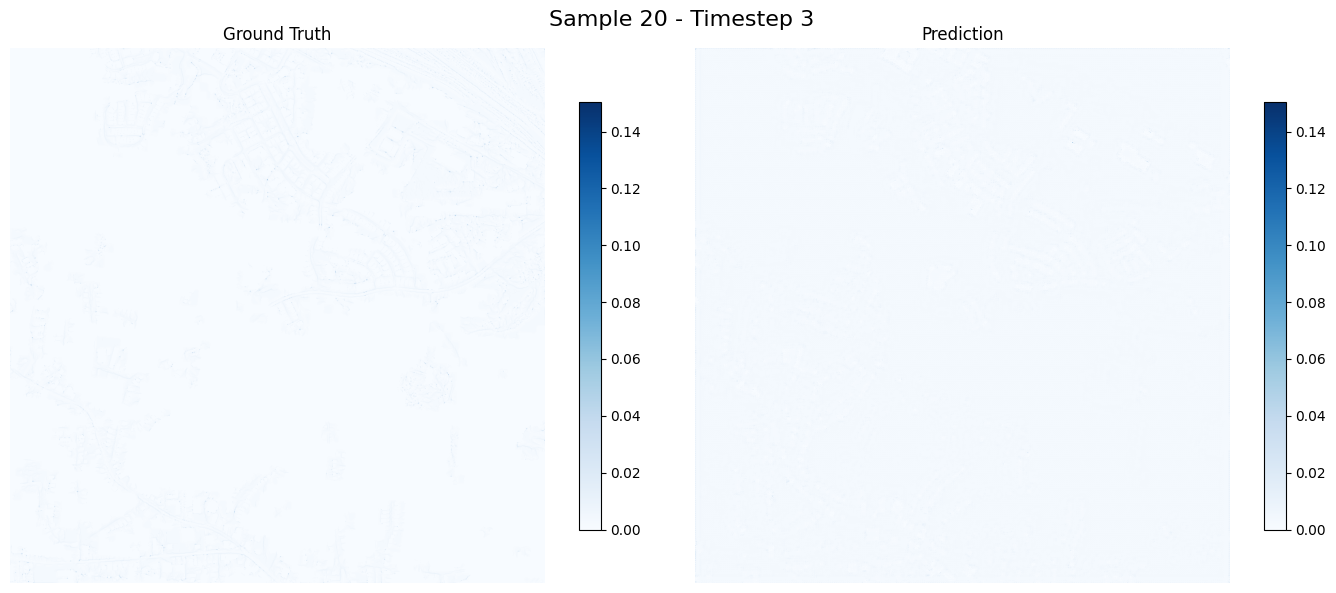

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from usl_models.flood_ml.dataset import load_dataset_windowed
from usl_models.flood_ml import constants

# Path to trained model
model_path = "/home/jainr/climateiq-cnn-5/logs/htune_project_20250430-182544/model"
model = tf.keras.models.load_model(model_path)

# Number of samples to visualize
n_samples = 20

# Loop through the dataset and predict
for i, (input_data, ground_truth) in enumerate(validation_dataset.take(n_samples)):
    ground_truth = ground_truth.numpy().squeeze()
    prediction = model(input_data).numpy().squeeze()

    print(f"\nSample {i+1} Prediction Stats:")
    print("  Min:", prediction.min())
    print("  Max:", prediction.max())
    print("  Mean:", prediction.mean())

    # Choose timestep to plot
    timestep = 3
    gt_t = ground_truth[timestep]
    pred_t = prediction[timestep]
    vmax_val = max(gt_t.max(), pred_t.max())

    # Plot Ground Truth and Prediction
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Sample {i+1} - Timestep {timestep}", fontsize=16)

    im1 = axes[0].imshow(gt_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")
    plt.colorbar(im1, ax=axes[0], shrink=0.8)

    im2 = axes[1].imshow(pred_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[1].set_title("Prediction")
    axes[1].axis("off")
    plt.colorbar(im2, ax=axes[1], shrink=0.8)

    plt.tight_layout()
    plt.show()


In [1]:
import pathlib
import time
import tensorflow as tf
import numpy as np
import keras
import keras_tuner
from usl_models.flood_ml.dataset import download_dataset, load_dataset_windowed_cached
from usl_models.flood_ml.model import FloodModel
from usl_models.flood_ml import constants
# === CONFIG ===
# === STEP 1: DOWNLOAD PREDICTION DATA TO FILECACHE (features only) ===
print(":inbox_tray: Downloading prediction features into local cache...")
filecache_dir = pathlib.Path("/home/shared/climateiq/filecache")
# study area(s) — used for geospatial features
study_areas = ["Atlanta_Prediction"]
# choose rainfall scenario explicitly (this selects temporal.npy)
rainfall_sim = "Atlanta-Atlanta_config/Rainfall_Data_22.txt"
download_dataset(
    sim_names=study_areas,
    output_path=filecache_dir,
    include_labels=False,                 # prediction mode
    rainfall_sim_name=rainfall_sim,      # pick the rainfall you want
)


2025-09-02 15:47:56.618057: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-02 15:47:56.670292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-02 15:47:56.670326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-02 15:47:56.671887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-02 15:47:56.680284: I tensorflow/core/platform/cpu_feature_guar

:inbox_tray: Downloading prediction features into local cache...
